# Model Selection for Smart Peak Splits

This notebook's objective is to select the model that will perform the desired predictions with the highest accuracy, once chosen, the model will be saved for the main pipeline at `orchestrator.py`

## Pipeline Overview

### Training Phase
1. **Data Collection**: GPX files are placed in `data/raw/` folder
2. **Feature Extraction**: Run `orchestrator.py` to parse GPX files and extract features (splits with distance, elevation, HR, pace, time)
3. **Model Training**: Train models on processed files from `data/processed/`
4. **Model Selection**: Evaluate and select the best performing model
5. **Save Model**: Save the selected model for inference

### Prediction Phase (After Training)
1. **Input**: New GPX file from user
2. **Parse GPX**: Extract splits data (distance, elevation, HR if available)
3. **Model Inference**: Predict for each split:
   - Time (seconds)
   - Average Pace (min/km)
   - Average HR (bpm)
4. **Output**: CSV with predicted splits performance

## Setup

Before proceeding, ensure to run `orchestrator.py` and that GPX files are available in the `data/raw/` folder. You will have processed files in `data/processed/` after running the orchestrator. The processed files are the ones that will be used for training and validating the model.

Please check the processed file sample at `data/samples/activity_20738496042_splits_sample.csv`

**Note**: There will be a sampling with 5 GPX files, those are supposed to be yours :)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import glob

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import StandardScaler
import pickle

## 1. Cargar y Preparar Datos

In [10]:
csv_folder = '../data/processed'

csv_files = glob.glob(os.path.join(csv_folder, '*.csv'))
print(f"Archivos encontrados: {len(csv_files)}\n")

if csv_files:
    first_file = csv_files[0]
    print(f"Inspeccionando: {os.path.basename(first_file)}")
    df_sample = pd.read_csv(first_file)
    print(f"\nColumnas: {df_sample.columns.tolist()}")
    print(f"\nPrimeras filas:")
    print(df_sample.head())

Archivos encontrados: 5

Inspeccionando: activity_20387932202_splits.csv

Columnas: ['Lap', 'Time', 'Distance', 'Avg Pace', 'Avg HR', 'Total Ascent', 'Total Descent']

Primeras filas:
   Lap      Time Distance Avg Pace  Avg HR Total Ascent Total Descent
0    1  00:14:14    1000m    14:13      86          26m           12m
1    2  00:14:07    1001m    14:06      87          20m            2m
2    3  00:13:41    1003m    13:38      92          48m            0m
3    4  00:15:55    1002m    15:52     113          74m            0m
4    5  00:18:06    1002m    18:03     112          85m            0m


In [12]:
csv_folder = '../data/processed'

all_data = []

for csv_file in glob.glob(os.path.join(csv_folder, '*.csv')):
    print(f"Cargando: {os.path.basename(csv_file)}")
    df = pd.read_csv(csv_file)
    
    df_mapped = pd.DataFrame()
    df_mapped['split_km'] = df['Lap']
    
    df_mapped['distance'] = df['Distance'].str.replace('m', '').astype(float) / 1000
    
    def parse_pace(pace_str):
        if pd.isna(pace_str):
            return np.nan
        parts = pace_str.split(':')
        return int(parts[0]) + int(parts[1]) / 60
    
    df_mapped['pace'] = df['Avg Pace'].apply(parse_pace)
    
    df_mapped['avg_hr'] = df['Avg HR']
    
    df_mapped['elevation_gain'] = df['Total Ascent'].str.replace('m', '').astype(float)
    df_mapped['elevation_loss'] = df['Total Descent'].str.replace('m', '').astype(float)
    
    df_mapped['cumulative_elevation_gain'] = df_mapped['elevation_gain'].cumsum()
    df_mapped['gradient'] = ((df_mapped['elevation_gain'] - df_mapped['elevation_loss']) / 
                              (df_mapped['distance'] * 1000 + 1e-6)) * 100
    
    all_data.append(df_mapped)

combined_df = pd.concat(all_data, ignore_index=True)

print(f"\nTotal splits cargados: {len(combined_df)}")
print(f"Columnas: {combined_df.columns.tolist()}")
print(f"Archivos procesados: {len(all_data)}")
print(f"\nPrimeras filas:")
combined_df.head()

Cargando: activity_20387932202_splits.csv
Cargando: activity_20395619433_splits.csv
Cargando: activity_20600745436_splits.csv
Cargando: activity_20669495648_splits.csv
Cargando: activity_20738496042_splits.csv

Total splits cargados: 124
Columnas: ['split_km', 'distance', 'pace', 'avg_hr', 'elevation_gain', 'elevation_loss', 'cumulative_elevation_gain', 'gradient']
Archivos procesados: 5

Primeras filas:


,split_km,distance,pace,avg_hr,elevation_gain,elevation_loss,cumulative_elevation_gain,gradient
0,1,1.000,14.216667,86,26.0,12.0,26.0,1.400000
1,2,1.001,14.100000,87,20.0,2.0,46.0,1.798202
2,3,1.003,13.633333,92,48.0,0.0,94.0,4.785643
3,4,1.002,15.866667,113,74.0,0.0,168.0,7.385230
4,5,1.002,18.050000,112,85.0,0.0,253.0,8.483034


## 2. Feature Engineering y Creación de Secuencias

In [13]:
sequence_length = 5

feature_columns = ['elevation_gain', 'elevation_loss', 'distance', 'cumulative_elevation_gain', 'gradient']
target_columns = ['pace', 'avg_hr']

X = combined_df[feature_columns].values
y = combined_df[target_columns].values

scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

print(f"Shape de X: {X_scaled.shape}")
print(f"Shape de y: {y_scaled.shape}")

Shape de X: (124, 5)
Shape de y: (124, 2)


In [14]:
def create_sequences(X, y, sequence_length):
    X_seq, y_seq = [], []
    for i in range(len(X) - sequence_length):
        X_seq.append(X[i:i + sequence_length])
        y_seq.append(y[i + sequence_length])
    return np.array(X_seq), np.array(y_seq)

X_seq, y_seq = create_sequences(X_scaled, y_scaled, sequence_length)

print(f"Shape de X_seq: {X_seq.shape}")
print(f"Shape de y_seq: {y_seq.shape}")

Shape de X_seq: (119, 5, 5)
Shape de y_seq: (119, 2)


## 3. División Train/Validation

In [15]:
split_idx = int(len(X_seq) * 0.8)

X_train = X_seq[:split_idx]
y_train = y_seq[:split_idx]
X_val = X_seq[split_idx:]
y_val = y_seq[split_idx:]

print(f"Train samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")

Train samples: 95
Validation samples: 24


## 4. Construcción del Modelo LSTM

In [33]:
model = Sequential()

model.add(LSTM(64, activation='tanh', return_sequences=True, input_shape=(sequence_length, len(feature_columns))))
model.add(Dropout(0.3))

model.add(LSTM(32, activation='tanh', return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(2, activation='linear'))

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 5, 64)          │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,586 (123.38 KB)

 Trainable params: 31,522 (123.13 KB)

 Non-trainable params: 64 (256.00 B)

## 5. Entrenamiento

In [34]:
os.makedirs('models', exist_ok=True)

early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)
checkpoint = ModelCheckpoint('models/best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop, checkpoint],
    verbose=1
)

Epoch 1/50
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - loss: 3.0512 - mae: 1.3179
Epoch 1: val_loss improved from None to 0.54507, saving model to models/best_model.keras
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 207ms/step - loss: 2.4401 - mae: 1.2147 - val_loss: 0.5451 - val_mae: 0.6196
Epoch 2/50
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1.4279 - mae: 0.9248
Epoch 2: val_loss improved from 0.54507 to 0.53960, saving model to models/best_model.keras
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 1.4692 - mae: 0.8971 - val_loss: 0.5396 - val_mae: 0.6155
Epoch 3/50
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 1.5838 - mae: 0.9097
Epoch 3: val_loss improved from 0.53960 to 0.53355, saving model to models/best_model.keras
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 1.4803 - mae: 0.9320 - val_loss: 0.5335 - val_mae: 0.6128
Epoch 4/50
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.2609 - mae: 0.9005
Epoch 4: val_loss improved from 0.53355 to 0.52817, saving model to models/best_model.keras
3/3 ━━━━━━━━

## 6. Visualización del Entrenamiento

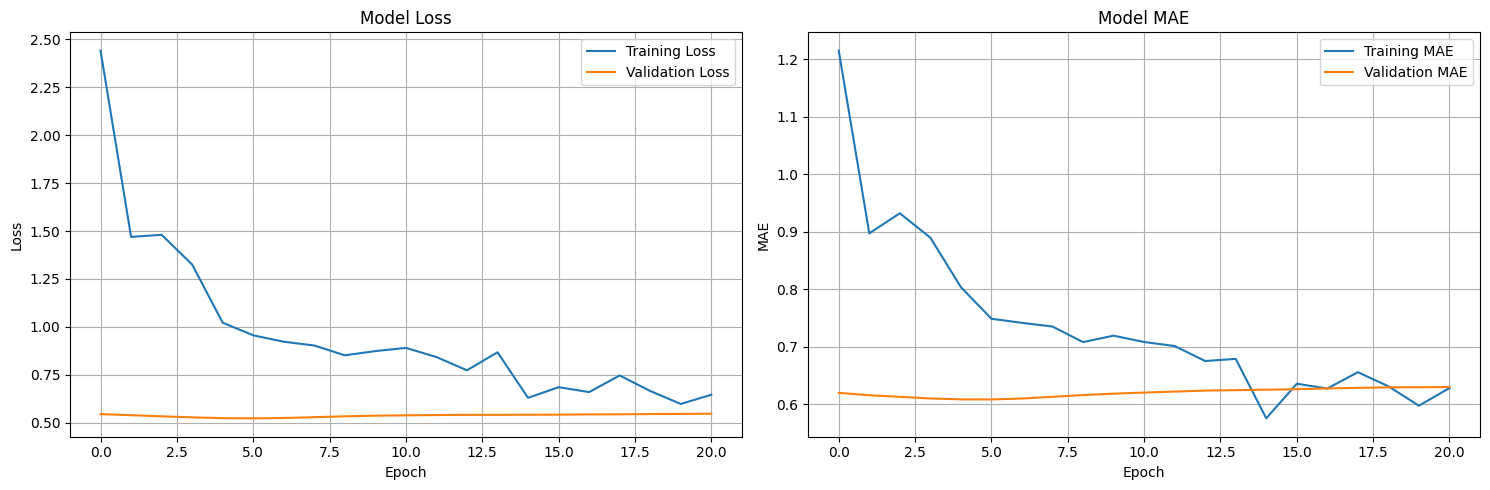

In [35]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('models/training_history.png')
plt.show()

## 7. Evaluación

In [36]:
results = model.evaluate(X_val, y_val, verbose=1)

print(f"\nValidation Loss: {results[0]:.4f}")
print(f"Validation MAE: {results[1]:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.5231 - mae: 0.6083

Validation Loss: 0.5231
Validation MAE: 0.6083


In [37]:
predictions = model.predict(X_val[:10])
predictions_original = scaler_y.inverse_transform(predictions)
y_val_original = scaler_y.inverse_transform(y_val[:10])

comparison_df = pd.DataFrame({
    'Real Pace': y_val_original[:, 0],
    'Pred Pace': predictions_original[:, 0],
    'Real HR': y_val_original[:, 1],
    'Pred HR': predictions_original[:, 1]
})

print("\nPrimeras 10 predicciones vs reales:")
comparison_df

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step

Primeras 10 predicciones vs reales:


,Real Pace,Pred Pace,Real HR,Pred HR
0,17.066667,17.680212,91.0,122.720169
1,10.616667,17.762381,114.0,122.358223
2,6.333333,17.770767,118.0,122.003639
3,9.550000,17.888123,120.0,122.046394
4,23.466667,17.733805,112.0,122.270721
5,27.650000,17.832701,113.0,122.355927
6,22.866667,17.915470,118.0,122.235542
7,22.216667,18.376343,117.0,121.582443
8,24.700000,18.812826,114.0,121.213036
9,25.100000,19.541590,122.0,121.311325


## 8. Guardar Modelo y Scalers

In [38]:
model.save('models/smart_peak_model.keras')

with open('models/scalers.pkl', 'wb') as f:
    pickle.dump({
        'scaler_X': scaler_X,
        'scaler_y': scaler_y,
        'sequence_length': sequence_length,
        'feature_columns': feature_columns,
        'target_columns': target_columns
    }, f)

print("Modelo guardado en: models/smart_peak_model.keras")
print("Scalers guardados en: models/scalers.pkl")

Modelo guardado en: models/smart_peak_model.keras
Scalers guardados en: models/scalers.pkl
